In [1]:
# import libraries 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

## Time Series Housing 

In [2]:
# fix Suburb column in historical rent dataset 

def fix_Suburb_names_in_historical_rental_data():
    
    """
    Fix Suburb names in the historical rental data 
    that contain non-alphabetic chars and/or unusual
    naming conventions. 
    
    Will be split into 3 sections I, II, III 
    
    """
    
    historical_rental_data = pd.read_csv('../data/raw/Weekly_Median_Suburb_Rents.csv').drop(columns=['Unnamed: 0'])
    
    #I. Split SA2s that encompass more than 1 Suburb, usually indicated by '-'
    
    #BUT those of the form Suburb - DIRECTION (DIRECTION e.g. north, east, etc)
    #are SA2s that only encompass a *part* of a Suburb
    #Note: $ is a metacharacter in regex, stating the end of the string
    SA2s_rental_w_multiple_Suburbs = historical_rental_data['Suburb'][
        (historical_rental_data['Suburb'].str.contains('-')) & 
        ~(historical_rental_data['Suburb'].str.contains('- North$')) &
        ~(historical_rental_data['Suburb'].str.contains('- South$')) &
        ~(historical_rental_data['Suburb'].str.contains('- East$')) &
        ~(historical_rental_data['Suburb'].str.contains('- West$')) 
    ]

    #split the Suburbs in each SA2 to individual Suburbs 
    SA2s_rental_w_multiple_Suburbs = SA2s_rental_w_multiple_Suburbs.str.split(r'\s*-\s*')


    #create empty dataframe with empty columns, for storing instances where SA2s 
    #comprised of multiple Suburbs
    rental_data_SA2s_w_multiple_Suburbs = pd.DataFrame(columns=historical_rental_data.columns)

    #extract the indexes
    SA2s_rental_w_multiple_Suburbs_index = SA2s_rental_w_multiple_Suburbs.index

    #iterator variable for obtaining indexes of instances for which SA2s are 
    #located in SA2s_unemp_data_w_multiple_Suburbs
    i = 0 

    for multiple_Suburbs_in_a_SA2 in SA2s_rental_w_multiple_Suburbs:

        #extract the corresponding index, so that we can modify the instance later
        idx = SA2s_rental_w_multiple_Suburbs_index[i]


        #for each individual Suburb in the SA2
        for individual_Suburb in multiple_Suburbs_in_a_SA2:

            #extract instance where its SA2 corresponding 
            #to multiple_Suburbs_in_a_SA2
            inst = historical_rental_data.loc[idx,:]

            #modify the SA2_Name, that contain multiple_Suburbs_in_a_SA2,  
            #into the individual Suburb "individual_Suburb"

            inst['Suburb'] = individual_Suburb

            #stack the row "inst" into unemp_data_SA2s_w_multiple_Suburbs
            rental_data_SA2s_w_multiple_Suburbs =\
                pd.concat([
                    pd.DataFrame([inst],columns=historical_rental_data.columns), 
                    rental_data_SA2s_w_multiple_Suburbs
                  ],
                  axis=0)

        i += 1

    rental_data_no_SA2_w_mult_subs = historical_rental_data[~historical_rental_data.index.\
                                                            isin(SA2s_rental_w_multiple_Suburbs.index)].\
    copy()

    rental_data_all_Suburb = pd.concat([rental_data_no_SA2_w_mult_subs,
               rental_data_SA2s_w_multiple_Suburbs],
              axis=0)

    #II. retain observations in 4th quarter of rental data
    
    rental_data_all_Suburb = rental_data_all_Suburb[
        rental_data_all_Suburb['Quarter'] == 4
    ]

    #III. as a result of collapsing Suburbs (or sa2s, rather) with dashes, 
    #we have to make sure that all of them are indeed Suburbs. Otherwise
    #if we can fix their namings, we fix them. 

    #obtain all Suburbs that are not in the lookup data 
    #these are listed in 'Suburbs_before_fixed' var below

    #Before that, remove obvious non-Suburbs in rental data
    rental_data_all_Suburb = rental_data_all_Suburb[
        ~rental_data_all_Suburb['Suburb'].isin(['Yarra Ranges', 'St Kilda Rd', 'CBD'])
    ]

    #do fuzzy string matching between Suburbs (that dont exist in lookup  data)
    #to Suburbs in lookup data. This is the result (code for fuzzy string matching not included)
    Suburbs_before_fixed = ['East St Kilda','East Hawthorn', 'East Brunswick','Ballarat',
     'Wanagaratta',
     'Bendigo East',
     'West St Kilda',
     'Mt Eliza',
     'Newcombe',
     'West Brunswick',
     'Mt Martha']

    Suburbs_fixed = ['St Kilda', 'Hawthorn East', 
                     'Brunswick', 'Ballarat East', 'Wangaratta',
                    'Bendigo', 'St Kilda West', 'Mount Eliza',
                    'Newcomb', 'Brunswick West', 'Mount Martha']

    fix_ambiguous_rental_Suburbs = dict(zip(Suburbs_before_fixed, Suburbs_fixed))

    #not all Suburbs need fixing. So other "safe" Suburbs can just stay as they are!
    def fix_ambiguous_Suburbs_rental(Suburb):
        """For the ambiguous Suburbs above, map them to the
        correct ones (in the rental data)"""

        if Suburb not in fix_ambiguous_rental_Suburbs:
            return Suburb
        else: 
            return fix_ambiguous_rental_Suburbs[Suburb]

    #fix the ambiguous Suburbs 
    rental_data_all_Suburb['Suburb'] = rental_data_all_Suburb['Suburb'].map(
        lambda Suburb: fix_ambiguous_Suburbs_rental(Suburb))
    
    #lastly, casefold all Suburb names into lower case.
    rental_data_all_Suburb['Suburb'] = rental_data_all_Suburb['Suburb'].\
                            str.lower()

    return rental_data_all_Suburb

fix_Suburb_names_in_historical_rental_data().to_csv('../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [3]:
df = pd.read_csv('../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv', index_col = 0)

df = df[df['Quarter'] == 4].reset_index(drop = True)
df['Year'] = df['Year'].astype(int)

In [4]:
# group data by region 

region_grp = df.groupby(['Year','Region'], as_index = False).mean()

### Median Rent in Victoria Regions - 2000 - 2020 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


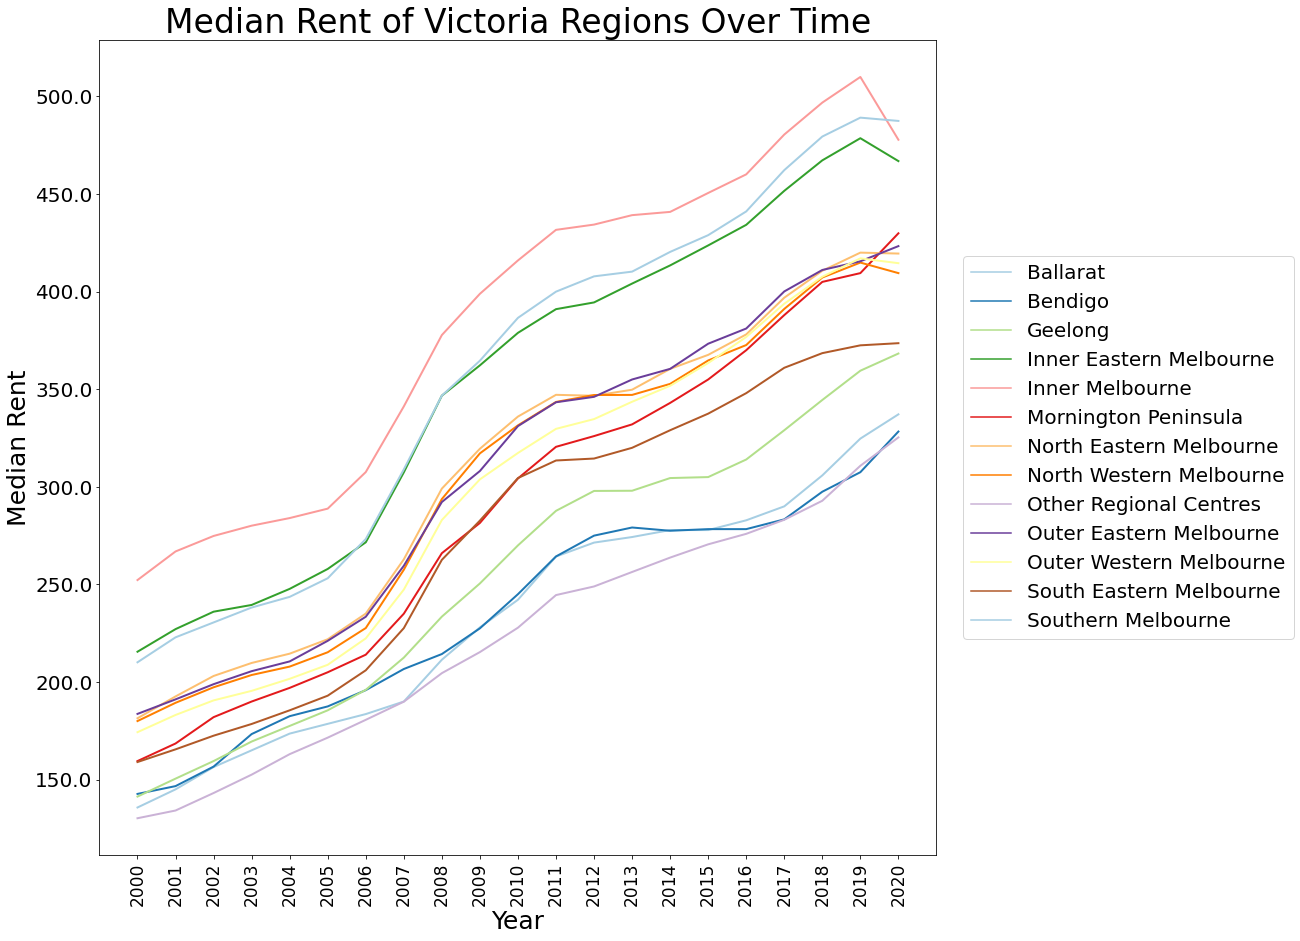

In [7]:
# Plotting 

plt.figure(figsize=(15, 15)) 

region_grp['Year'] = region_grp['Year'].astype(str)

fig = sns.lineplot(x="Year", y="Median",
             hue="Region",
             data=region_grp,      
             linewidth = 2, 
             palette = "Paired")

fig.set_title('Median Rent of Victoria Regions Over Time', size = 33)
fig.set_yticklabels(fig.get_yticks(), size = 20)
fig.set_xticklabels([i + 2000 for i in fig.get_xticks()], size = 17, rotation = 90)
fig.set_ylabel('Median Rent', size = 25)
fig.set_xlabel('Year', size = 25)
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})

In [6]:
percentage_changes = df.copy()

# calculate YoY percentage change in rent for all Suburbs 

percentage_changes.sort_values(['Suburb','Year'], inplace = True, ascending=[True, True])

percentage_changes['pct_chg'] = (percentage_changes.groupby('Suburb')['Median']
                                  .apply(pd.Series.pct_change) + 1)

percentage_changes.head()

,Year,Quarter,Region,Suburb,Median,pct_chg
4443,2000,4,Inner Melbourne,abbotsford,240.0,NaN
4317,2001,4,Inner Melbourne,abbotsford,250.0,1.041667
4191,2002,4,Inner Melbourne,abbotsford,260.0,1.040000
4065,2003,4,Inner Melbourne,abbotsford,265.0,1.019231
3939,2004,4,Inner Melbourne,abbotsford,275.0,1.037736


In [7]:
# calculate average YoY percentage change in rent for all Suburbs 

prc_changes_mean = percentage_changes.groupby(['Region', 'Suburb'], as_index = False).mean().sort_values(by =['pct_chg'], ascending = False)

ten_highest = prc_changes_mean.head(10).reset_index(drop = True)
ten_lowest = prc_changes_mean.tail(10).reset_index(drop = True)

### Top 10 Suburbs with Highest YoY Pecentage Change in Rent for all Suburbs 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Suburbs with Highest (Average) Increace in Rent Since 2000')

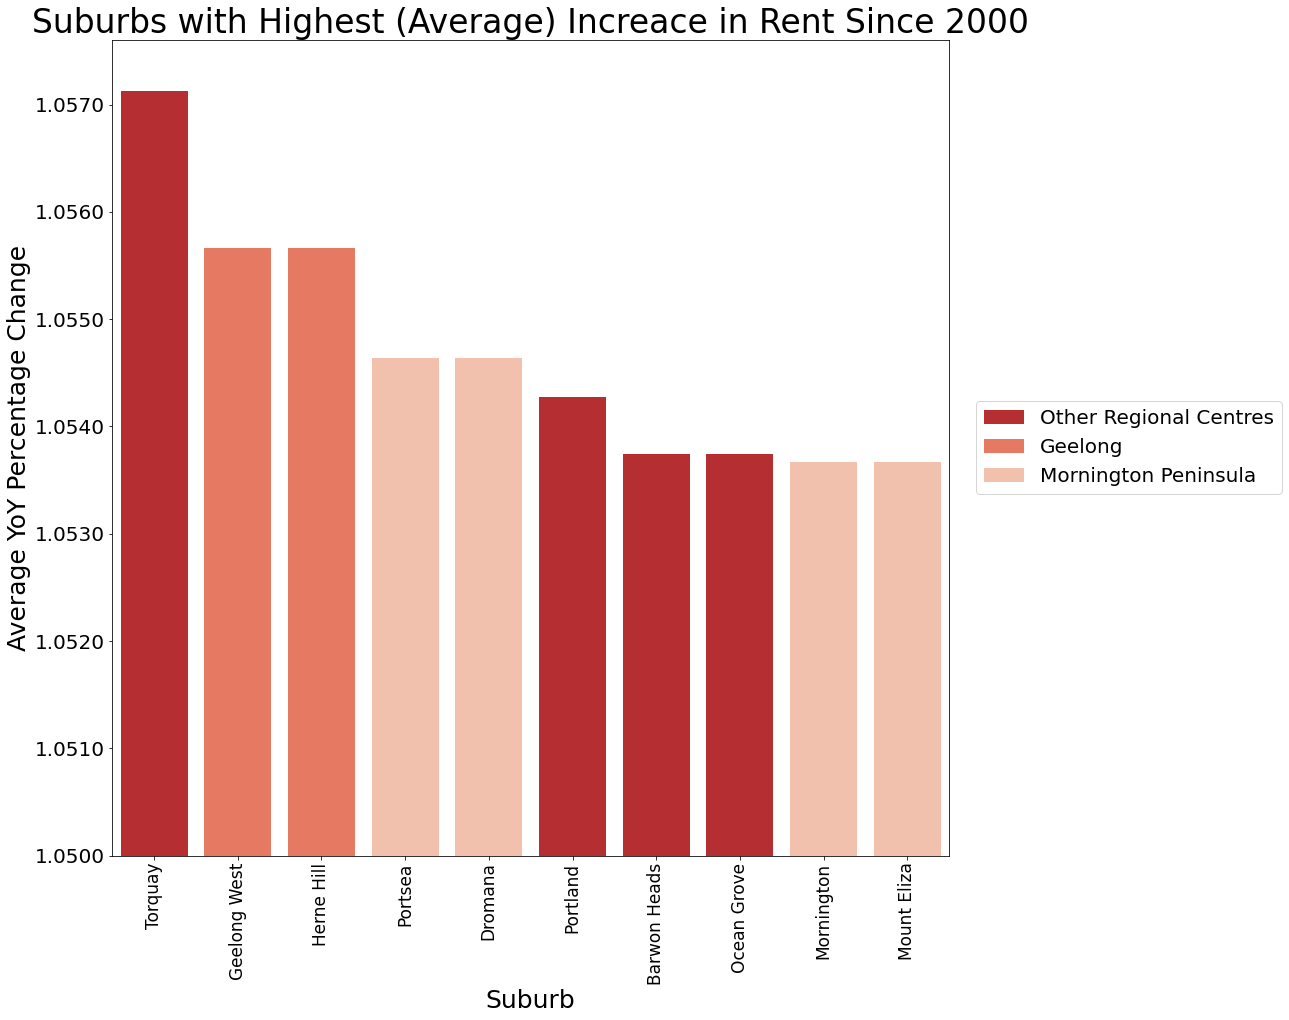

In [8]:
# Plotting Top 10 Suburbs with Highest YoY Pecentage Change in Rent for all Suburbs

plt.figure(figsize=(15, 15)) 
fig = sns.barplot(x = 'Suburb', y = 'pct_chg', hue = 'Region', data = ten_highest, palette = 'Reds_r' ,  dodge=False)
fig.set(ylim=(1.05, 1.0576))
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})

fig.set_ylabel('Average YoY Percentage Change', size = 25)
fig.set_xlabel('Suburb', size = 25)

fig.set_yticklabels(fig.get_yticks(), size = 20)
fig.set_xticklabels([i.title() for i in ten_highest['Suburb']], size = 17, rotation = 90)
fig.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.set_title('Suburbs with Highest (Average) Increace in Rent Since 2000', size = 33)

### Top 10 Suburbs with Lowest YoY Pecentage Change in Rent for all Suburbs

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Suburbs with Lowest (Average) Increace in Rent Since 2000')

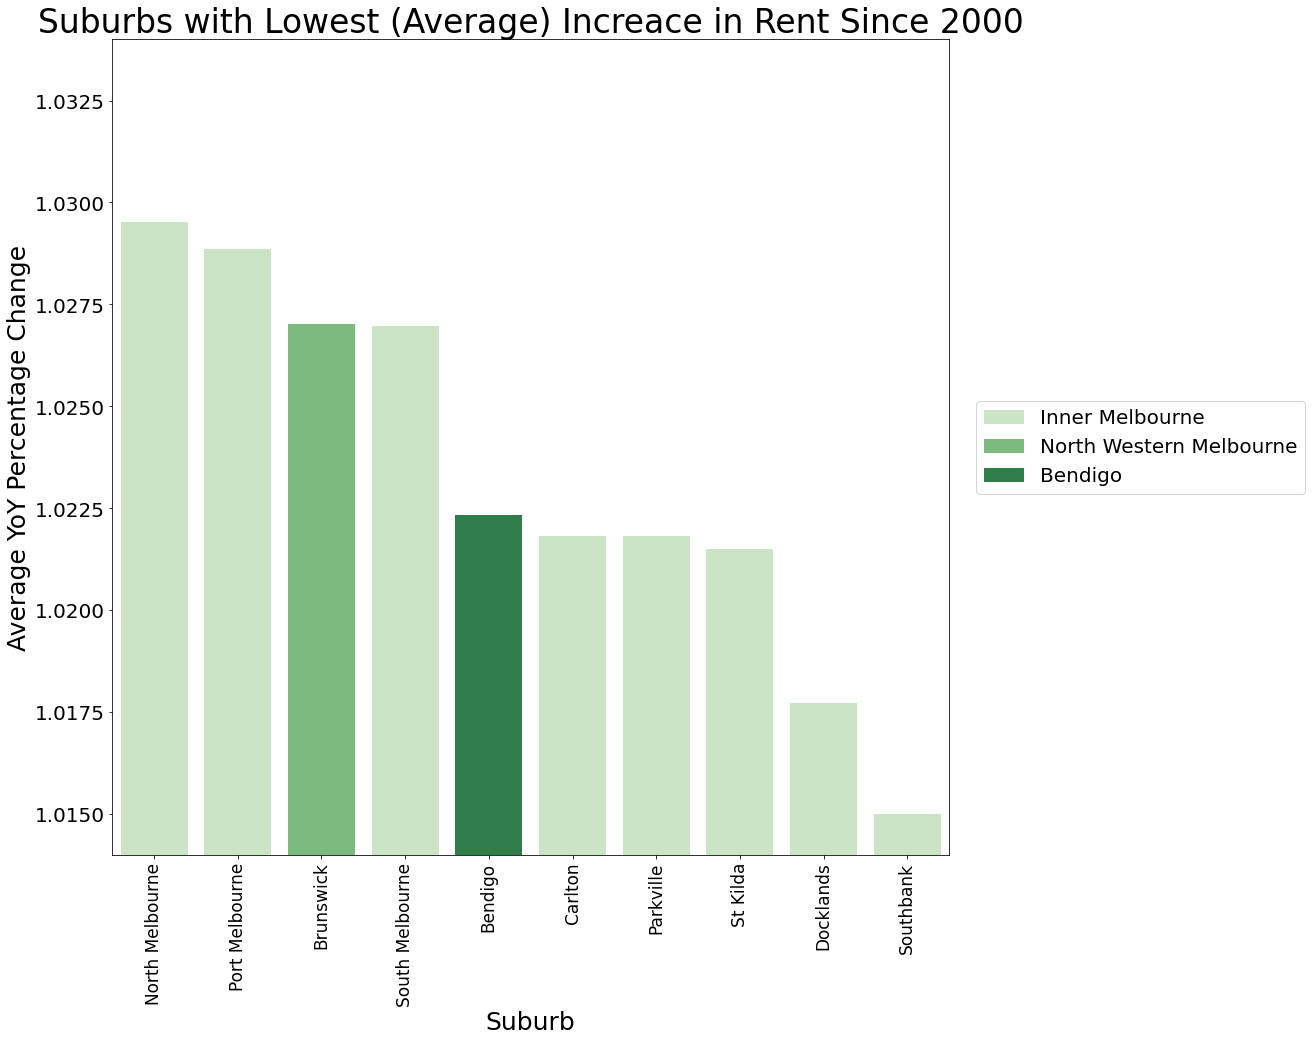

In [9]:
# plotting Top 10 Suburbs with Lowest YoY Pecentage Change in Rent for all Suburbs

plt.figure(figsize=(15, 15)) 
fig = sns.barplot(x = 'Suburb', y = 'pct_chg', hue = 'Region', data = ten_lowest, palette = 'Greens' , dodge=False)
fig.set(ylim=(1.014, 1.034))
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})

fig.set_ylabel('Average YoY Percentage Change', size = 25)
fig.set_xlabel('Suburb', size = 25)

fig.set_yticklabels(fig.get_yticks(), size = 20)
fig.set_xticklabels([i.title() for i in ten_lowest['Suburb']], size = 17, rotation = 90)

fig.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.set_title('Suburbs with Lowest (Average) Increace in Rent Since 2000', size = 33)

In [10]:
# calculate volatility (standard deviation) for YoY percentage changes in rent for all Suburbs 

prc_changes_std = percentage_changes.groupby(['Region', 'Suburb'], as_index = False). \
            std().sort_values(by =['pct_chg'], ascending = False)


twenty_highest = prc_changes_std.head(20).reset_index(drop = True)
twenty_lowest = prc_changes_std.tail(20).reset_index(drop = True)

twenty_highest.head(10)

,Region,Suburb,Year,Quarter,Median,pct_chg
0,North Western Melbourne,brunswick,6.128701,0.0,90.055758,0.111948
1,Inner Melbourne,st kilda,6.128701,0.0,78.976452,0.072752
2,Other Regional Centres,hamilton,6.204837,0.0,50.100185,0.072507
3,Inner Melbourne,docklands,5.627314,0.0,71.716629,0.068816
4,Inner Melbourne,southbank,6.204837,0.0,79.662981,0.067882
5,North Eastern Melbourne,alphington,6.204837,0.0,92.095318,0.062781
6,North Eastern Melbourne,fairfield,6.204837,0.0,92.095318,0.062781
7,Southern Melbourne,brighton east,6.204837,0.0,149.704582,0.062592
8,North Western Melbourne,keilor,6.204837,0.0,80.049925,0.062541
9,Inner Melbourne,east melbourne,6.204837,0.0,86.466922,0.061774


### Top 20 Suburbs with most Volatile YoY Pecentage Change in Rent 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Suburbs with Highest Volatility in Rent Since 2000')

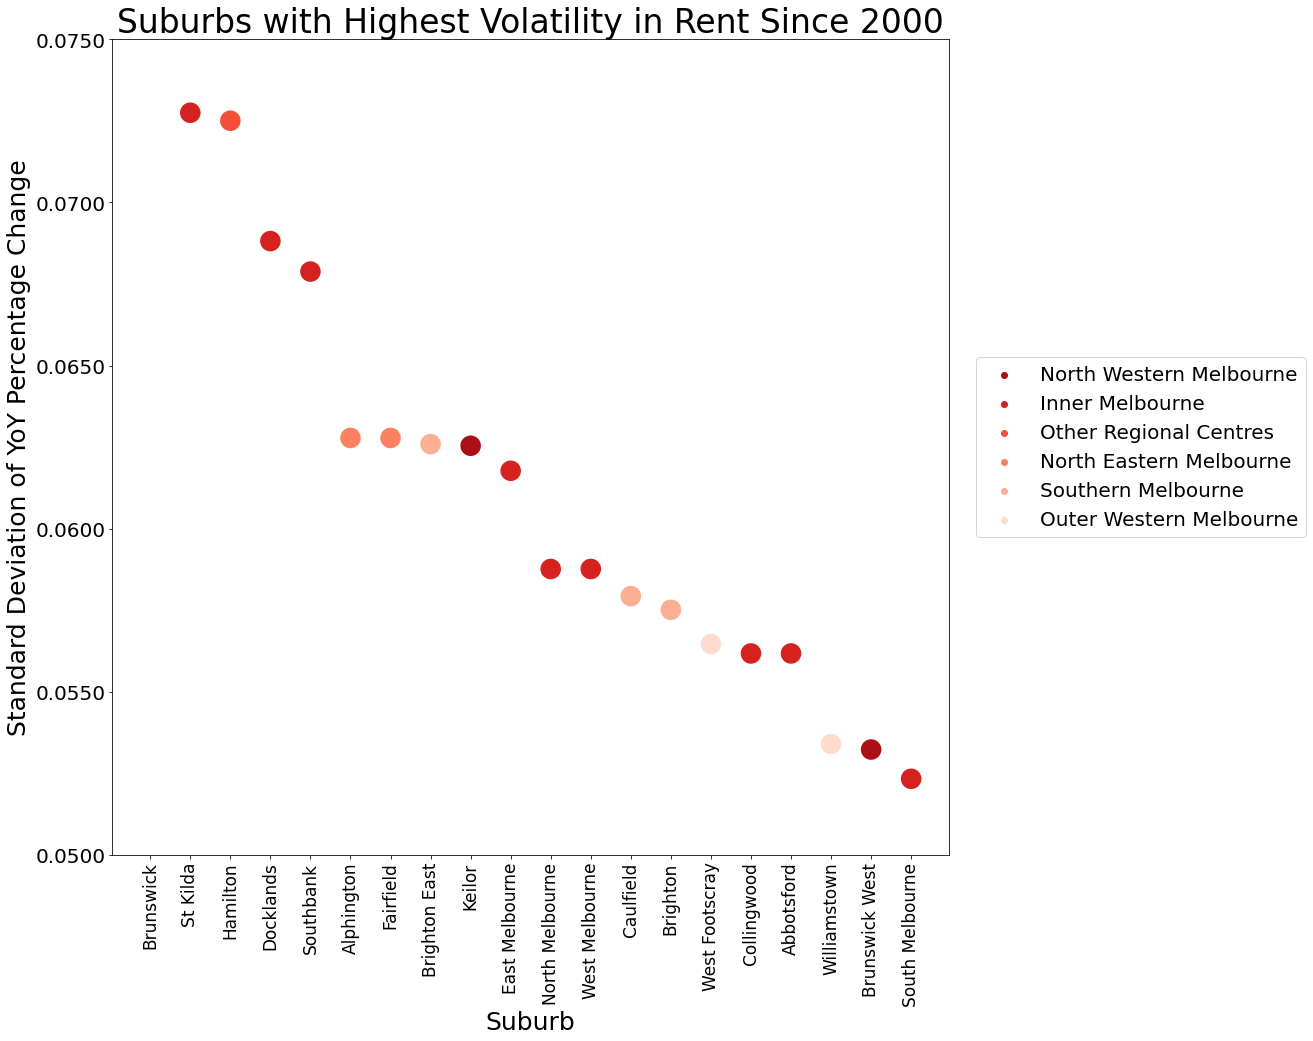

In [11]:
# Plotting Suburbs with Highest Volatility in Rent Changes Since 2000

plt.figure(figsize=(15, 15)) 
fig = sns.scatterplot(x = 'Suburb', y = 'pct_chg', hue = 'Region', data = twenty_highest, palette = 'Reds_r', s=500)

fig.set(ylim=(0.05, 0.075))

fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})

fig.set_ylabel('Standard Deviation of YoY Percentage Change', size = 25)
fig.set_xlabel('Suburb', size = 25)

fig.set_yticklabels(fig.get_yticks(), size = 20)
fig.set_xticklabels([i.title() for i in twenty_highest['Suburb']], size = 17, rotation = 90)

fig.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.set_title('Suburbs with Highest Volatility in Rent Since 2000', size = 33)

### Top 20 Suburbs with least YoY Pecentage Change in Rent 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Suburbs with Lowest Volatility in Rent Since 2000')

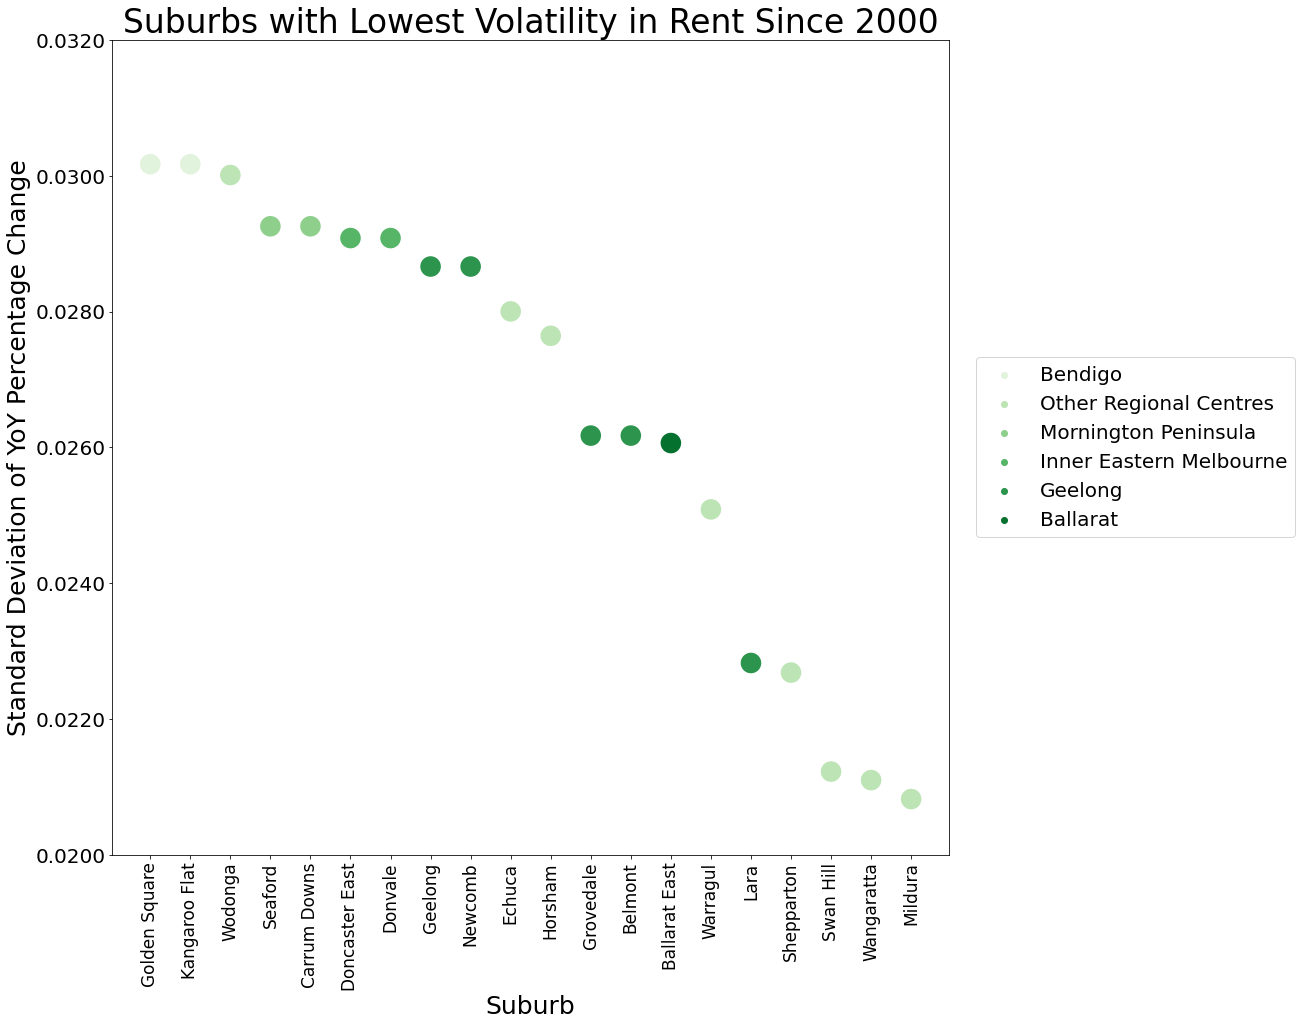

In [12]:
# plotting Suburbs with Lowest Volatility in Rent Changes Since 2000

plt.figure(figsize=(15, 15)) 
fig = sns.scatterplot(x = 'Suburb', y = 'pct_chg', hue = 'Region', data = twenty_lowest, palette = 'Greens', s=500)

fig.set(ylim=(0.02, 0.032))

fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})

fig.set_ylabel('Standard Deviation of YoY Percentage Change', size = 25)
fig.set_xlabel('Suburb', size = 25)

fig.set_yticklabels(fig.get_yticks(), size = 20)
fig.set_xticklabels([i.title() for i in twenty_lowest['Suburb']], size = 17, rotation = 90)

fig.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.set_title('Suburbs with Lowest Volatility in Rent Since 2000', size = 33)